# Classification of Anomalous Diffusion

We'll develop a recurrent neural network to classify different kinds of motions obeying different anomalous diffusion models.

## Load Anomalous Diffusion Models

We load the `datasets_theory()` class from the `andi_datasets` package.

In [2]:
from andi_datasets.datasets_theory import datasets_theory

AnDi = datasets_theory()
model_names = AnDi.avail_models_name
model_number = len(model_names)

print(f"{model_number} nomalous diffusion models: {model_names}")


5 nomalous diffusion models: ['attm', 'ctrw', 'fbm', 'lw', 'sbm']


## Simulate Trajectories

We now proceed to simulate the necessary trajectories for the dataset. This might take a few minutes. This will generate `N = 4000` trajectories for each anomalous diffusion model, each with random anomalous diffusion coefficients. Each trajectory contains `T = 100` time steps.

The dataset contains rows with lenght `2 + D * T`, with the following structure:
* First column: model label 
* Second column: value of the anomalous exponent
* Following columns: trajectories

In [8]:
from numpy import concatenate as cat
from numpy.random import rand

T = 100  # Time steps.
N = 4000  # Trajectories per model.
D = 2  # Dimensionality.

dataset = cat((
    AnDi.create_dataset(
        T=T, 
        N_models=1, 
        exponents=(rand(N) + 0.2) / 1.2,
        models=[0, 1],  # attm, ctrw
        dimension=D, 
    ),
    AnDi.create_dataset(
        T=T, 
        N_models=1, 
        exponents=(rand(N) * 1.8) + 0.2,
        models=[2, 4],  # fbm, sbm
        dimension=D, 
    ),
    AnDi.create_dataset(
        T=T, 
        N_models=1, 
        exponents=rand(N) + 1,
        models=3,  # lw
        dimension=D, 
    ),
), axis=0)

print(f"{dataset.shape}")

(20000, 202)


## adding localization noise

We now shuffle the dataset and extract the model numbers, anomalous exponents, and the x and y components of the trajectories.

In [14]:
from numpy.random import shuffle

shuffle(dataset)

models = dataset[:, 0]
exponents = dataset[:, 1]
trajectories = dataset[:, 2:].reshape(-1, T, D, order='F')


## Visualize Trajectories

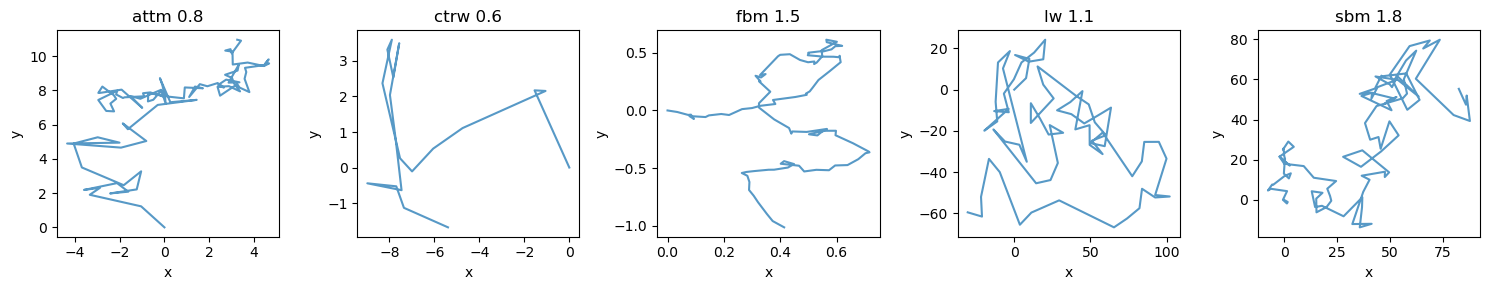

In [32]:
import matplotlib.pyplot as plt
from numpy import where

fig, axs = plt.subplots(1, model_number, figsize=((15, 3)), tight_layout=True)

for m, ax in zip(range(model_number), axs):
    idx = where(models == m)[0][0]
    ax.plot(trajectories[idx, :, 0], trajectories[idx, :, 1], alpha = 0.75)
    ax.set_title(f"{model_names[m]} {exponents[idx]:.1f}")
    plt.setp(ax, xlabel="x", ylabel="y")

## utils

In [ ]:
def standardize(disp):    
    disp -= disp.mean(axis=1, keepdims=True)
    disp /=  disp.std(axis=1, keepdims=True)
    return disp

def digits_to_one_hot(digits, nclasses): 
    from numpy import zeros
    one_hot_labels = zeros((digits.shape[0], nclasses))
    for idx, digit in enumerate(digits): 
        one_hot_labels[idx, digit] = 1
    return one_hot_labels
    
def one_hot_to_digit(one_hot_labels): 
    from numpy import argmax
    return argmax(one_hot_labels , axis=-1)

def accuracy(predictions, groundtruths):
# Both predictions and ground truths are given in one-hot format
    predictions = one_hot_to_digit(predictions) 
    groundtruths = one_hot_to_digit(groundtruths)
    correct = sum(predictions == groundtruths)
    total = predictions.shape[0]
    return correct / total

## Prepare Data

## Simple RNN

In [ ]:
import sys
sys.path.append('./deeplay') #if deeplay is not pip-installed
import deeplay as dl
import torch

n_timesteps=int(T/window_size)
n_features=dim*window_size
n_outputs=5

rnn = dl.RNN(n_features,hidden_features=[100],out_features=n_outputs,dropout=0.2,rnn_type="RNN")
model = dl.Classifier(rnn, loss=torch.nn.CrossEntropyLoss(),optimizer=dl.Adam(lr=0.001))
model=model.create()
print(model)


In [ ]:
def train_and_predict(model,epochs=30):
    trainer = dl.Trainer(max_epochs=epochs,accelerator="auto")
    trainer.fit(model, train_loader,val_dataloaders=val_loader)

    test_output = trainer.predict(model, test_loader)

    y_test = []
    for batch in test_loader:
        y_test.append(batch[1])
    
    y_test = torch.cat(y_test, dim=0)
    test_output = torch.cat(test_output, dim=0)
    
    return y_test,test_output
    
y_test,predicted_y=train_and_predict(model)
computed_accuracy = accuracy(predicted_y, y_test)
print ("Accuracy:" , computed_accuracy)


In [ ]:
from seaborn import heatmap , cubehelix_palette
from numpy import zeros

def confusion_matrix(predicted_y,y_test):
    # Compute the confusion matrix
    confusion_matrix = zeros((5, 5))
    predicted = one_hot_to_digit(predicted_y)
    groundtruth = one_hot_to_digit(y_test)
    for groundtruth_m , predicted_m in zip(groundtruth , predicted):
        confusion_matrix[ predicted_m, groundtruth_m ] += 1
    confusion_matrix=100.*confusion_matrix/confusion_matrix.sum(axis=0,keepdims=1)
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8)) 
    heatmap(confusion_matrix, annot=True, fmt=".1f", square=True, cmap=cubehelix_palette(light=0.95, as_cmap=True), vmax =100)
    plt.ylabel("Predicted model", fontsize=15)
    plt.xlabel("Ground truth model", fontsize=15) 
    locs, NA = plt.xticks() 
    plt.xticks(ticks=locs, labels=model_names)
    locs, NA = plt.yticks() 
    plt.yticks(ticks=locs, labels=model_names)

    plt.show()

confusion_matrix(predicted_y,y_test)

## GRU

In [ ]:
rnn.blocks[0].layer.configure(torch.nn.GRU)
model = dl.Classifier(rnn, loss=torch.nn.CrossEntropyLoss(),optimizer=dl.Adam(lr=0.01))
model=model.create()
print(model)

y_test,predicted_y=train_and_predict(model)
computed_accuracy = accuracy(predicted_y, y_test)
print ("Accuracy:" , computed_accuracy)
confusion_matrix(predicted_y,y_test)

## LSTM

In [ ]:
rnn.blocks[0].layer.configure(torch.nn.LSTM)
rnn.blocks[0].layer.configure(hidden_size=50) #to bring the total parameter count more in-line with a simple RNN
rnn.blocks[1].layer.configure(in_features=50)
model = dl.Classifier(rnn, loss=torch.nn.CrossEntropyLoss(),optimizer=dl.Adam(lr=0.01))
model=model.create()
print(model)

y_test,predicted_y=train_and_predict(model)
computed_accuracy = accuracy(predicted_y, y_test)
print ("Accuracy:" , computed_accuracy)
confusion_matrix(predicted_y,y_test)

## Bidirectional LSTM

In [ ]:
rnn = dl.RNN(n_features,hidden_features=[50],out_features=n_outputs,dropout=0.2,rnn_type="LSTM",bidirectional=True)
model = dl.Classifier(rnn, loss=torch.nn.CrossEntropyLoss(),optimizer=dl.Adam(lr=0.01))
model=model.create()
print(model)

y_test,predicted_y=train_and_predict(model)
computed_accuracy = accuracy(predicted_y, y_test)
print ("Accuracy:" , computed_accuracy)
confusion_matrix(predicted_y,y_test)

## Adding layers to LSTM (overfitting)

In [ ]:
rnn = dl.RecurrentNeuralNetwork(n_features,hidden_features=[100],out_features=30)
rnn.blocks.layer.configure(torch.nn.LSTM)
rnn.blocks.dropout.configure(p=0.2)

dense_top=dl.MultiLayerPerceptron(in_features=None,hidden_features=[15],out_features=n_outputs)
dense_top.blocks.dropout.configure(p=0.2)

dense_rnn = dl.Sequential(rnn,dense_top)
model = dl.Classifier(dense_rnn, loss=torch.nn.CrossEntropyLoss(),optimizer=dl.Adam(lr=0.01))
model=model.create()
print(model)

y_test,predicted_y=train_and_predict(model)
computed_accuracy = accuracy(predicted_y, y_test)
print ("Accuracy:" , computed_accuracy)
confusion_matrix(predicted_y,y_test)